In [1]:
from sqlalchemy import create_engine
import pandas as pd

/tmp/ipykernel_42816/1481486818.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def database_connect(user, password, host, port, db):
    engine = create_engine(
        f'postgresql://{user}:{password}@{host}:{port}/{db}')
    engine.connect()
    return engine

In [3]:
db_engine = database_connect('root', 'root', 'postgres-db', '5432', 'RetailDB')

In [15]:
sql = '''
    SELECT * 
    FROM online_retail_cleaned
'''
retail_cleaned_df = pd.read_sql(sql, db_engine, index_col='Id')
df_copy = retail_cleaned_df.copy()

retail_cleaned_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Id,,,,,,,,
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France


# Online Retail Sales Data Warehouse 

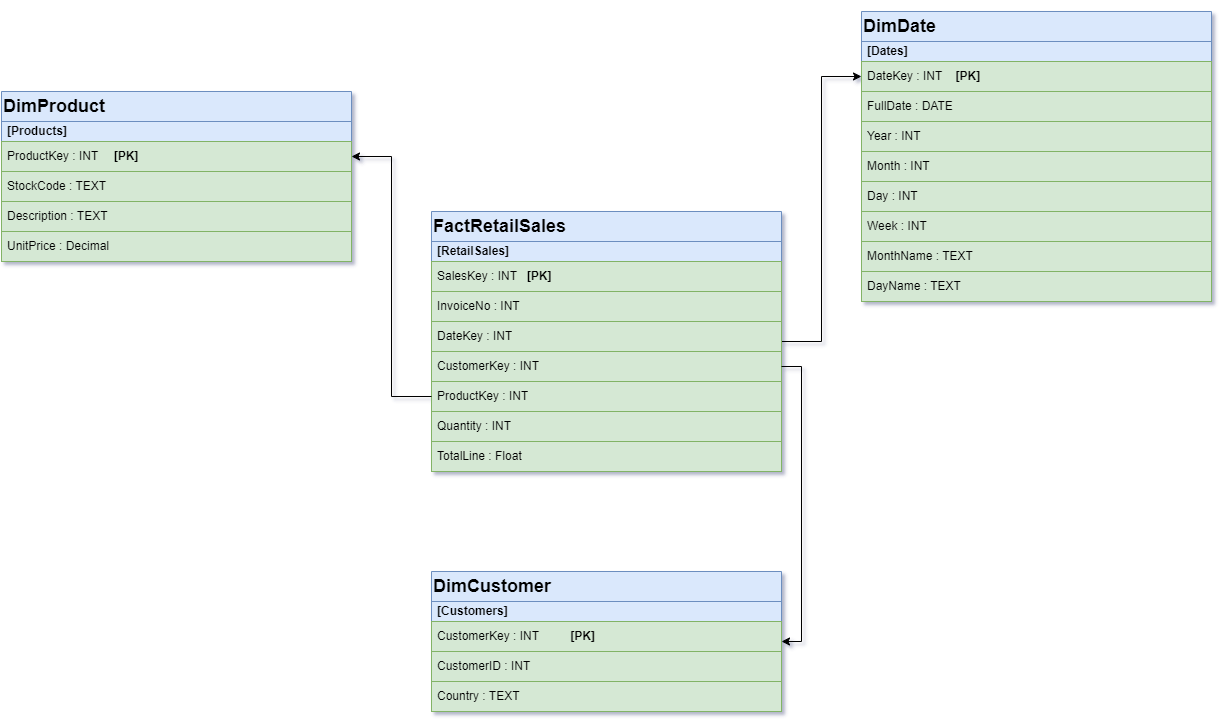

## 1. `DimDate` Dimension Table

In [22]:
retail_cleaned_df['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [19]:
retail_cleaned_df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

Build the `DimDate` table with sequence of dates from **2010-01-01** to **2012-01-01**

In [23]:
sql = '''
SELECT CAST(to_char(date_trunc('day', days)::date, 'YYYYMMDD') AS INT) AS "DateKey"
	, date_trunc('day', days):: date AS "FullDate"
	, EXTRACT(YEAR FROM days) AS "Year"
	, EXTRACT(MONTH FROM days) AS "Month"
	, EXTRACT(DAY FROM days) AS "Day"
	, EXTRACT(WEEK FROM days) AS "Week"
	, TO_CHAR(days, 'Month') AS "MonthName"
	, TO_CHAR(days, 'Day') AS "DayName"
FROM generate_series
        ( '2010-01-01'::timestamp 
        , '2012-01-01'::timestamp
        , '1 day'::interval) days;
'''
date_df = pd.read_sql(sql, db_engine, index_col='DateKey')
date_df

,FullDate,Year,Month,Day,Week,MonthName,DayName
DateKey,,,,,,,
20100101,2010-01-01,2010.0,1.0,1.0,53.0,January,Friday
20100102,2010-01-02,2010.0,1.0,2.0,53.0,January,Saturday
20100103,2010-01-03,2010.0,1.0,3.0,53.0,January,Sunday
20100104,2010-01-04,2010.0,1.0,4.0,1.0,January,Monday
20100105,2010-01-05,2010.0,1.0,5.0,1.0,January,Tuesday
...,...,...,...,...,...,...,...
20111228,2011-12-28,2011.0,12.0,28.0,52.0,December,Wednesday
20111229,2011-12-29,2011.0,12.0,29.0,52.0,December,Thursday
20111230,2011-12-30,2011.0,12.0,30.0,52.0,December,Friday


In [26]:
date_df.dtypes

FullDate      object
Year         float64
Month        float64
Day          float64
Week         float64
MonthName     object
DayName       object
dtype: object

In [27]:
date_df['Year'] = date_df['Year'].astype(int)
date_df['Month'] = date_df['Month'].astype(int)
date_df['Day'] = date_df['Day'].astype(int)
date_df['Week'] = date_df['Week'].astype(int)
date_df.dtypes

FullDate     object
Year          int64
Month         int64
Day           int64
Week          int64
MonthName    object
DayName      object
dtype: object

In [29]:
date_df.head()

,FullDate,Year,Month,Day,Week,MonthName,DayName
DateKey,,,,,,,
20100101,2010-01-01,2010,1,1,53,January,Friday
20100102,2010-01-02,2010,1,2,53,January,Saturday
20100103,2010-01-03,2010,1,3,53,January,Sunday
20100104,2010-01-04,2010,1,4,1,January,Monday
20100105,2010-01-05,2010,1,5,1,January,Tuesday


In [30]:
from time import time 

In [37]:
t_start = time()
date_df.to_sql(name='DimDate', con=db_engine, if_exists='replace', index=True, index_label='DateKey')
print(f'Finished insertion in {time()-t_start:.3}s')

Finished insertion in 0.0626s


In [ ]:
# ALTER TABLE public."DimDate" ADD PRIMARY KEY ("DateKey")

## 2. `DimCustomer` Dimension Table

In [46]:
retail_cleaned_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Id,,,,,,,,
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France


In [73]:
customer_df = retail_cleaned_df[['CustomerID', 'Country']].drop_duplicates().copy()
customer_df = customer_df.reset_index(drop=True)
customer_df.index.names = ['CustomerKey']
customer_df

,CustomerID,Country
CustomerKey,,
0,17850,United Kingdom
1,13047,United Kingdom
2,12583,France
3,13748,United Kingdom
4,15100,United Kingdom
...,...,...
4375,13436,United Kingdom
4376,15520,United Kingdom
4377,13298,United Kingdom


In [75]:
t_start = time()
customer_df.to_sql(name='DimCustomer', con=db_engine, if_exists='replace', index=True, index_label='CustomerKey')
print(f'Finished insertion in {time()-t_start:.3}s')

Finished insertion in 0.099s
